In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

# LURUS

In [ ]:
bag = rosbag.Bag('bag/get_31_LURUS.bag')
# print(bag)

## CHECK 

In [ ]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

x = []
y = []
yaw = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/get_waypoints']):
    x.append(msg.x)
    y.append(msg.y)
    yaw.append(msg.yaw)
    t.append(msg.header.stamp.to_sec())
x = np.array(x)
y = np.array(y)
yaw = wrap_angle(np.array(yaw) * (-1) - np.pi*3/2)
t = np.array(t)

lim = [0, -1]
plt.scatter(X_fm[lim[0]:lim[1],0], X_fm[lim[0]:lim[1],1], s=3., label='gps')
plt.scatter(x,y,s=2., label='get_wp_gps_imu')
plt.legend()
plt.show()

In [ ]:
# Filter the waypoints and remove the outlier !
X = np.copy(x)
Y = np.copy(y)
T = np.copy(t)
YAW = np.copy(yaw)

for m in range(6):
    X_filtered = savgol_filter(X, 51, 3)
    Y_filtered = savgol_filter(Y, 51, 3)
    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)
    X = X[dist <= 0.5]
    Y = Y[dist <= 0.5]
    T = T[dist <= 0.5]
    YAW = YAW[dist <= 0.5]
    if m % 1 == 0:
        None
#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
#         plt.plot(X, Y, label='Outlier Rejection')
#         plt.legend()
#         plt.title('Iterasi ke-{}'.format(m))
#         plt.show()
plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
plt.plot(X, Y, label='Outlier Rejection')
plt.legend()
plt.title('Iterasi ke-{}'.format(m))
plt.show()

In [ ]:
num_f = 201

dst = 0.1

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

## INTERPOLATING THE WAYPOINTS

In [ ]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.085 #m/s ~ 1.8 km/jam
vstop = 0.085
vmax = 0.25 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 20.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 25:
        vel[i] = 0.0
    elif s[i] >= 17:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [ ]:
# # VELOCITY

# # Generate the velocity
# v0 = 0.5 #m/s ~ 1.8 km/jam
# vstop = 0.5
# vmax = 1.5 #m/s ~ 5.4 km/jam
# accel = 0.15 #m/s2
# num = wp_x_f.shape[0]
# vel = [v0]
# const = 20.
# for i in range(1, num):
#     vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
# vel = np.array(vel)

# for i in range(num):
#     if s[i] >= 25:
#         vel[i] = 0.0
#     elif s[i] >= 17:
#         vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

# plt.plot(s, vel)

In [ ]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [ ]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [ ]:
np.save('waypoints/31_agus_wp_lurus', wp_interp)
wp_interp.shape

# S

In [ ]:
bag = rosbag.Bag('bag/get_31_S.bag')
# print(bag)

## CHECK 

In [ ]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

x = []
y = []
yaw = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/get_waypoints']):
    x.append(msg.x)
    y.append(msg.y)
    yaw.append(msg.yaw)
    t.append(msg.header.stamp.to_sec())
x = np.array(x)
y = np.array(y)
yaw = wrap_angle(np.array(yaw) * (-1) - np.pi*3/2)
t = np.array(t)

lim = [0, -1]
plt.scatter(X_fm[lim[0]:lim[1],0], X_fm[lim[0]:lim[1],1], s=3., label='gps')
plt.scatter(x,y,s=2., label='get_wp_gps_imu')
plt.legend()
plt.show()

In [ ]:
# Filter the waypoints and remove the outlier !
X = np.copy(x)
Y = np.copy(y)
T = np.copy(t)
YAW = np.copy(yaw)

for m in range(6):
    X_filtered = savgol_filter(X, 51, 3)
    Y_filtered = savgol_filter(Y, 51, 3)
    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)
    X = X[dist <= 0.5]
    Y = Y[dist <= 0.5]
    T = T[dist <= 0.5]
    YAW = YAW[dist <= 0.5]
    if m % 1 == 0:
        None
#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
#         plt.plot(X, Y, label='Outlier Rejection')
#         plt.legend()
#         plt.title('Iterasi ke-{}'.format(m))
#         plt.show()
plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
plt.plot(X, Y, label='Outlier Rejection')
plt.legend()
plt.title('Iterasi ke-{}'.format(m))
plt.show()

In [ ]:
wp_x.shape

In [ ]:
num_f = 161

dst = 0.1

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

## INTERPOLATING THE WAYPOINTS

In [ ]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.085 #m/s ~ 1.8 km/jam
vstop = 0.085
vmax = 0.25 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 20.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 25:
        vel[i] = 0.0
    elif s[i] >= 17:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [ ]:
# # VELOCITY

# # Generate the velocity
# v0 = 0.5 #m/s ~ 1.8 km/jam
# vstop = 0.5
# vmax = 1.5 #m/s ~ 5.4 km/jam
# accel = 0.15 #m/s2
# num = wp_x_f.shape[0]
# vel = [v0]
# const = 20.
# for i in range(1, num):
#     vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
# vel = np.array(vel)

# for i in range(num):
#     if s[i] >= 25:
#         vel[i] = 0.0
#     elif s[i] >= 17:
#         vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

# plt.plot(s, vel)

In [ ]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [ ]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [ ]:
np.save('waypoints/31_agus_wp_S', wp_interp)
wp_interp.shape

# BELOK

In [3]:
bag = rosbag.Bag('bag/get_31_BELOK.bag')
# print(bag)

## CHECK 

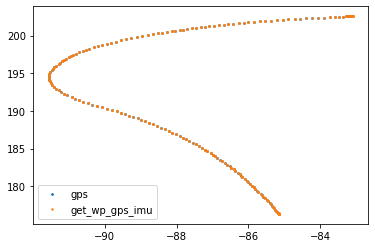

In [4]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

x = []
y = []
yaw = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/get_waypoints']):
    x.append(msg.x)
    y.append(msg.y)
    yaw.append(msg.yaw)
    t.append(msg.header.stamp.to_sec())
x = np.array(x)
y = np.array(y)
yaw = wrap_angle(np.array(yaw) * (-1) - np.pi*3/2)
t = np.array(t)

lim = [0, -1]
plt.scatter(X_fm[lim[0]:lim[1],0], X_fm[lim[0]:lim[1],1], s=3., label='gps')
plt.scatter(x,y,s=2., label='get_wp_gps_imu')
plt.legend()
plt.show()

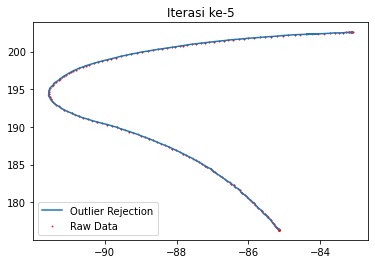

In [5]:
# Filter the waypoints and remove the outlier !
X = np.copy(x)
Y = np.copy(y)
T = np.copy(t)
YAW = np.copy(yaw)

for m in range(6):
    X_filtered = savgol_filter(X, 51, 3)
    Y_filtered = savgol_filter(Y, 51, 3)
    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)
    X = X[dist <= 0.5]
    Y = Y[dist <= 0.5]
    T = T[dist <= 0.5]
    YAW = YAW[dist <= 0.5]
    if m % 1 == 0:
        None
#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
#         plt.plot(X, Y, label='Outlier Rejection')
#         plt.legend()
#         plt.title('Iterasi ke-{}'.format(m))
#         plt.show()
plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
plt.plot(X, Y, label='Outlier Rejection')
plt.legend()
plt.title('Iterasi ke-{}'.format(m))
plt.show()

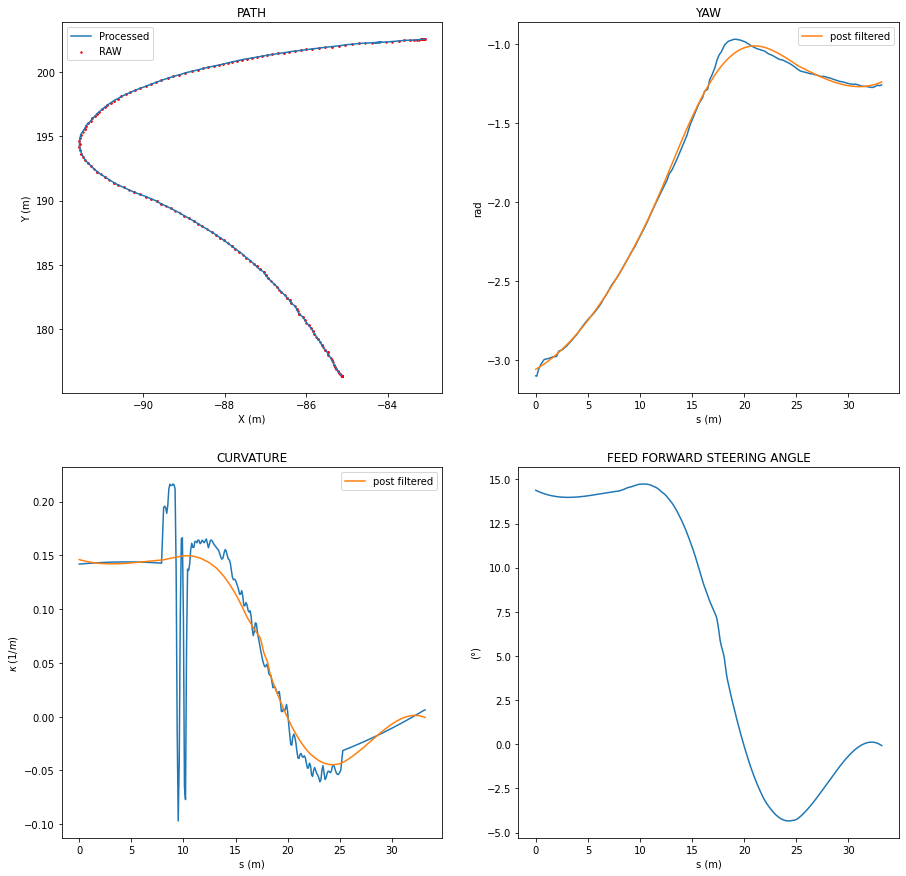

In [6]:
num_f = 161

dst = 0.1

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

## INTERPOLATING THE WAYPOINTS

In [7]:
# # # THROTTLEEEEE

# # # Generate the velocity
# v0 = 0.085 #m/s ~ 1.8 km/jam
# vstop = 0.085
# vmax = 0.25 #m/s ~ 5.4 km/jam
# accel = 0.005 #m/s2
# num = wp_x_f.shape[0]
# vel = [v0]
# const = 20.
# for i in range(1, num):
#     vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
# vel = np.array(vel)

# for i in range(num):
#     if s[i] >= 28:
#         vel[i] = 0.0
#     elif s[i] >= 19:
#         vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

# plt.plot(s, vel)

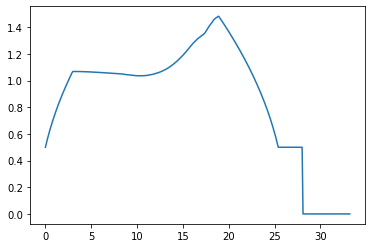

In [8]:
# VELOCITY

# Generate the velocity
v0 = 0.5 #m/s ~ 1.8 km/jam
vstop = 0.5
vmax = 1.5 #m/s ~ 5.4 km/jam
accel = 0.15 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 20.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 28:
        vel[i] = 0.0
    elif s[i] >= 19:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [9]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [10]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [11]:
# np.save('waypoints/31_agus_wp_belok', wp_interp)
# wp_interp.shape

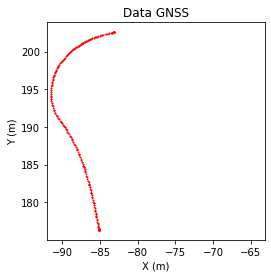

In [12]:
plt.scatter(X, Y, s=0.5, color='red')
plt.axis('square')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Data GNSS')
plt.savefig('img/x_y_gnss.png', transparent=True, dpi=600)
plt.show()

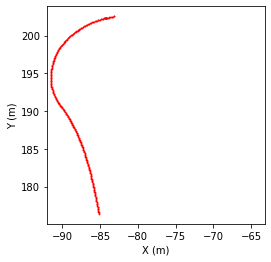

In [13]:
plt.scatter(wp_x, wp_y, color='red', s=0.5)
plt.axis('square')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig('img/x_y_eq_spaced.png', transparent=True, dpi=600)
plt.show()

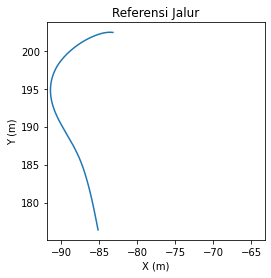

In [14]:
plt.plot(wp_interp[:,0], wp_interp[:,1])
plt.axis('square')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Referensi Jalur')
plt.savefig('img/x_y_interp.png', transparent=True, dpi=600)
plt.show()

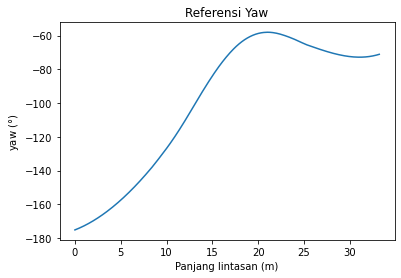

In [15]:
plt.plot(s, waypoints_np[:,2]*180/np.pi)
plt.xlabel('Panjang lintasan (m)')
plt.ylabel(r'yaw $(\degree)$')
plt.title('Referensi Yaw')
plt.savefig('img/yaw_ref.png', transparent=True, dpi=600)
plt.show()

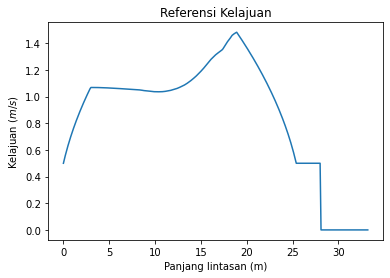

In [16]:
plt.plot(s, waypoints_np[:, 3])
plt.xlabel('Panjang lintasan (m)')
plt.ylabel(r'Kelajuan $(m/s)$')
plt.title('Referensi Kelajuan')
plt.savefig('img/kelajuan_ref.png', transparent=True, dpi=600)
plt.show()

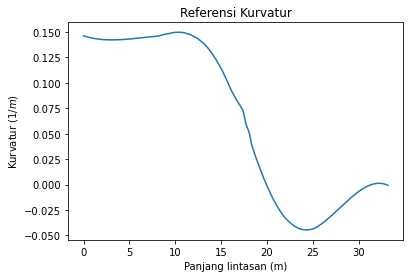

In [17]:
plt.plot(s, waypoints_np[:, 4])
plt.xlabel('Panjang lintasan (m)')
plt.ylabel(r'Kurvatur $(1/m)$')
plt.title('Referensi Kurvatur')
plt.savefig('img/kurvatur_ref.png', transparent=True, dpi=600)
plt.show()

# BELOK BESAR

In [ ]:
bag = rosbag.Bag('bag/get_31_BELOK_BESAR.bag')
# print(bag)

## CHECK 

In [ ]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

x = []
y = []
yaw = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/get_waypoints']):
    x.append(msg.x)
    y.append(msg.y)
    yaw.append(msg.yaw)
    t.append(msg.header.stamp.to_sec())
x = np.array(x)
y = np.array(y)
yaw = wrap_angle(np.array(yaw) * (-1) - np.pi*3/2)
t = np.array(t)

lim = [0, -1]
plt.scatter(X_fm[lim[0]:lim[1],0], X_fm[lim[0]:lim[1],1], s=3., label='gps')
plt.scatter(x,y,s=2., label='get_wp_gps_imu')
plt.legend()
plt.show()

In [ ]:
# Filter the waypoints and remove the outlier !
X = np.copy(x)
Y = np.copy(y)
T = np.copy(t)
YAW = np.copy(yaw)

for m in range(6):
    X_filtered = savgol_filter(X, 51, 3)
    Y_filtered = savgol_filter(Y, 51, 3)
    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)
    X = X[dist <= 0.5]
    Y = Y[dist <= 0.5]
    T = T[dist <= 0.5]
    YAW = YAW[dist <= 0.5]
    if m % 1 == 0:
        None
#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
#         plt.plot(X, Y, label='Outlier Rejection')
#         plt.legend()
#         plt.title('Iterasi ke-{}'.format(m))
#         plt.show()
plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
plt.plot(X, Y, label='Outlier Rejection')
plt.legend()
plt.title('Iterasi ke-{}'.format(m))
plt.show()

In [ ]:
wp_x.shape

In [ ]:
num_f = 121

dst = 0.2

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

## INTERPOLATING THE WAYPOINTS

In [ ]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.085 #m/s ~ 1.8 km/jam
vstop = 0.085
vmax = 0.25 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
cost = 20.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 50:
        vel[i] = 0.0
    elif s[i] >= 41:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [ ]:
# # VELOCITY

# # Generate the velocity
# v0 = 0.5 #m/s ~ 1.8 km/jam
# vstop = 0.5
# vmax = 1.5 #m/s ~ 5.4 km/jam
# accel = 0.15 #m/s2
# num = wp_x_f.shape[0]
# vel = [v0]
# const = 20.
# for i in range(1, num):
#     vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
# vel = np.array(vel)

# for i in range(num):
#     if s[i] >= 50:
#         vel[i] = 0.0
#     elif s[i] >= 41:
#         vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

# plt.plot(s, vel)

In [ ]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [ ]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [ ]:
np.save('waypoints/31_agus_wp_belok_besar', wp_interp)
wp_interp.shape